# QRM project - Hate speech on X

### Count coloumn
- number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF)
### Hate speech column
- number of CF users who judged the tweet to be hate speech
### offensive_laungage column
- number of CF users who judged the tweet to be offensive
### Niehter column
- number of CF users who judged the tweet to be neither offensive nor non-offensive
### Class column
- class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
### Text column
- text tweet



### info
- The numbers in the columns 2-4 is the number of people that belives the tweet is 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import string
import re
import regex
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
nltk.download('wordnet')
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikkelpedersen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mikkelpedersen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import zipfile
with zipfile.ZipFile('/Users/mikkelpedersen/Desktop/uni/Kandidat/3_semester/QRM/hate_speech_dataset_eksamen.zip', 'r') as z:
    f = z.open('labeled_data.csv')
    hs = pd.io.parsers.read_table(f, index_col=0, sep=',')
    
hs.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<class 'pandas.core.frame.DataFrame'>
Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB
None
----------------------------------------
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64
----------------------------------------
Column: count
3    22807
6     1571
4      211
9      167
7       27
Name: count, dtype: int64
Column: hate_speech
0    19790
1     3419
2     1251
3      287
4       21
5        7
6        5
7        3
Name: count, dty

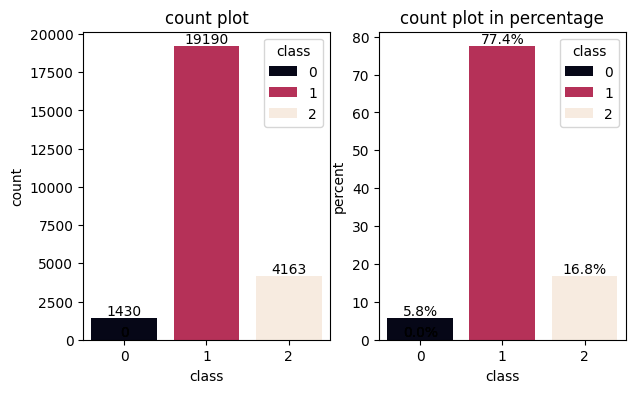

In [3]:
def info(df, x_col):
    print(df.info())
    print('-'*40)
    print(df.isna().sum())
    print('-'*40)
    for col in df.columns:
        if col != 'tweet':
            print(f'Column: {df[col].value_counts()}')
    print('-'*40)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(7,4))
    sns.countplot(df, x=x_col, hue=x_col, palette='rocket', ax=ax[0])
    ax[0].set_title('count plot')
    for p in ax[0].patches:
        ax[0].annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')
    sns.countplot(df, x=x_col, hue=x_col, palette='rocket', stat='percent', ax=ax[1])
    ax[1].set_title('count plot in percentage')
    for p in ax[1].patches:
        percentage = f'{p.get_height():.1f}%'
        ax[1].annotate(percentage, 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                   textcoords='offset points')
        
        

def class_distrbution(df, x_col):
    fig, ax = plt.subplots(1, 2, figsize=(7,4))
    sns.countplot(df, x=x_col, hue=x_col, palette='rocket', ax=ax[0])
    ax[0].set_title('count plot')
    for p in ax[0].patches:
        ax[0].annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                    textcoords='offset points')
    sns.countplot(df, x=x_col, hue=x_col, palette='rocket', stat='percent', ax=ax[1])
    ax[1].set_title('count plot in percentage')
    for p in ax[1].patches:
        percentage = f'{p.get_height():.1f}%'
        ax[1].annotate(percentage, 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), 
                   textcoords='offset points')
        
        

def length_dis(data, col1, col2):
    mean_class_dis = data['length_tweet'].mean()
    fig, ax = plt.subplots(1,1,figsize = (8,5))
    sns.histplot(data,
                x = col1,
                bins = 80,
                hue = col2,
                ax = ax)
    plt.axvline(mean_class_dis, color='red', linestyle='--')

    print(data[col1].sort_values(ascending=False).head(10))




info(hs, 'class')

The classes is super imbalanced and should defently be corrected

In [4]:
hs['length_tweet'] = hs['tweet'].apply(lambda x: len(x))

In [5]:
class_column = 'class'
average_lengths = hs.groupby(class_column)['length_tweet'].mean()

for class_name, avg_length in average_lengths.items():
    print(f"Average tweet length for class '{class_name}': {avg_length:.2f} characters")


Average tweet length for class '0': 84.59 characters
Average tweet length for class '1': 83.46 characters
Average tweet length for class '2': 94.85 characters


The average length of the tweets do not look like it could distrurb the models

18267    754
13733    657
1631     637
16918    522
19305    455
7644     452
19214    447
18111    392
20289    362
20389    343
Name: length_tweet, dtype: int64


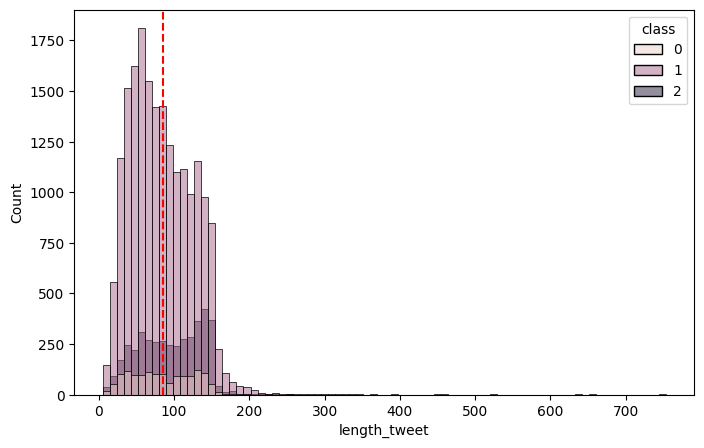

In [6]:
length_dis(hs, 'length_tweet', 'class')

In [7]:
hs = hs.drop(columns=hs[['count', 'hate_speech', 'offensive_language', 'neither']])
hs.head()

,class,tweet,length_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,140
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137


## Preprocessing

Since you have a large number of samples in the majority class, using SMOTE or Random Oversampling for classes 0 and 2 would likely work well without significant risk of overfitting. 
If you find that this increases noise, consider combining SMOTE with Tomek Links for more refined boundary samples.

In [8]:
stemmer = PorterStemmer()
stop_word = stopwords.words('english')

tt = TweetTokenizer()

def preporcessing(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    words = [word for word in text.split() if word not in stop_word]
    text = ' '.join(stemmer.stem(word) for word in words)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    
    text = tt.tokenize(text)
    return text

In [9]:
hs['tweet_preprocessed'] = hs['tweet'].apply(preporcessing)
hs['tweet_preprocessed'] = hs['tweet_preprocessed'].apply(' '.join)

In [10]:
hs.head(20)

,class,tweet,length_tweet,tweet_preprocessed
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,140,rt mayasolov woman shouldnt complain clean hou...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85,rt mleew 17 boy dat coldtyga dwn bad cuffin da...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120,rt urkindofbrand dawg rt 80sbaby4lif ever fuck...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62,rt cganderson vivabas look like tranni
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137,rt shenikarobert shit hear might true might fa...
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",158,tmadisonx shit blow meclaim faith somebodi sti...
6,1,"!!!!!!""@__BrighterDays: I can not just sit up ...",105,brighterday sit hate anoth bitch got much shit go
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,98,8220selfiequeenbri caus im tire big bitch come...
8,1,""" &amp; you might not get ya bitch back &amp; ...",58,amp might get ya bitch back amp that
9,1,""" @rhythmixx_ :hobbies include: fighting Maria...",55,rhythmixx hobbi includ fight mariam bitch


In [11]:
X = hs['tweet_preprocessed']
y = hs['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_copy = X_train.copy(deep=True)
X_test_copy = X_test.copy(deep=True)

In [12]:
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

len(vectorizer.vocabulary_)

32026

In [13]:
vectorizer.vocabulary_

{'talk': 28217,
 'angela': 6701,
 'hoe': 15178,
 'lol': 20288,
 'trick': 29511,
 'nicca': 22439,
 'left': 19806,
 'right': 25413,
 '12851412851': 932,
 'bitch': 8026,
 'get': 13917,
 'stuff': 27860,
 'done': 11718,
 'httptcogvfpk': 15933,
 '65ah5': 3574,
 'artalegaspar': 6944,
 'got': 14254,
 'flameee': 13139,
 'vivaalakatyy': 30472,
 'brotherbill': 8735,
 'jhuff': 18417,
 'good': 14202,
 'choke': 9667,
 'like': 20025,
 'say': 26039,
 'word': 31301,
 'pussi': 24580,
 'ion': 17805,
 'forehead': 13301,
 'hairlin': 14615,
 'lie': 19981,
 'amp': 6620,
 'approv': 6852,
 'shit': 26590,
 '4128514': 2743,
 'httpstco': 15457,
 '8madf35zx': 5561,
 'mingtong': 21494,
 '007': 10,
 'still': 27724,
 'cunt': 10644,
 'feel': 12926,
 'bad': 7340,
 'tho': 28938,
 'ya': 31540,
 'girl': 14016,
 'log': 20278,
 'nigger': 22523,
 'rt': 25677,
 'polokingbc': 24105,
 'relationshipgo': 25162,
 'httptcoge': 15897,
 '9koimygj': 5893,
 'mrnwachukwu': 21904,
 'naw': 22258,
 'boy': 8466,
 'trash': 29432,
 'start': 2

In [14]:
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_resmp, y_train_resmp = smote.fit_resample(X_train, y_train)


from collections import Counter
print("Resampled y_train distribution:", Counter(y_train_resmp))

Resampled y_train distribution: Counter({1: 15352, 2: 15352, 0: 15352})


# Models


In [15]:
mlb = MultinomialNB()
lr = LogisticRegression(multi_class='multinomial' ,solver='saga', penalty='l2', C=10, class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
svm = SVC(class_weight='balanced', kernel='rbf', C=5.0, gamma='scale', random_state=42)

def train_model(model):
    for model in [model]:
        model.fit(X_train_resmp, y_train_resmp)
        y_pred = model.predict(X_test)
        print(f"Model: {model.__class__.__name__}")
        train_acc = round(model.score(X_train_resmp, y_train_resmp)*100, 3)# Maybe not the best for a imbalanced dataset
        test_acc = round(accuracy_score(y_test, y_pred)*100, 3) # Maybe not the best for a imbalanced dataset
        print('The accuracy for the traning set: ', train_acc)
        print('The accuracy for the test set: ', test_acc)
        print('-' * 40)
        return y_pred 
    
    
def classification_repo(model, y_test, y_pred):
    for model in [model]:
        print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    
    classes = {
        0: 'Hate speech',
        1: 'Offensive speech',
        2: 'Nither'}
    labels = list(classes.values())

    fig,ax = plt.subplots(1,1,figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=labels, yticklabels=labels,ax=ax, cbar=False)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_res = cross_val_score(lr, X_train_resmp, y_train_resmp, cv=kf)

In [ ]:
print(cv_res)

In [ ]:
y_pred_lr = train_model(lr)
#y_pred_rf = train_model(rf)
#y_pred_svm = train_model(svm)

In [ ]:
classification_repo(lr, y_test, y_pred_lr)

In [16]:
lr_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2', 'elasticnet', 'none']}
rf_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
svm_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'gamma': ['scale', 'auto']}

def best_grid_search(model):
    print('Best  parameters found by grid search:', model.best_params_ )
    print('Best score for the model', model.best_score_)
    print('-' * 40)



def grid_search(model, param_grid):
    grid_model = GridSearchCV(model, 
                                param_grid=param_grid, 
                                cv=5, 
                                scoring='accuracy', 
                                verbose=2, n_jobs=-1)

    grid_model.fit(X_train_resmp, y_train_resmp)
        
        # Print results
    print(f"Model: {model.__class__.__name__}")
    best_grid_search(grid_model)
    grid_y_pred = grid_model.predict(X_test)
    return grid_y_pred

        

In [ ]:
grid_search(lr, lr_grid)

In [ ]:
eclf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf)],
    voting='soft')  # Using soft voting to consider the confidence level of each classifier


for clf, label in zip([eclf], ['Ensemble']):
    clf.fit(X_train_resmp, y_train_resmp)
    y_pred = clf.predict(X_test)
    print(f"\nModel: {label}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print("f1_macro: %0.2f (+/- %0.2f) [%s]" % (y_pred.mean(), y_pred.std(), label))
    print('-'*100)
    print(classification_report(y_test, y_pred))
    
    classes = {
        0: 'Hate speech',
        1: 'Offensive speech',
        2: 'Nither'}
    labels = list(classes.values())
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    plt.show()

In [31]:
from tensorflow.keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,SpatialDropout1D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [18]:
X_train_resmp_nn = X_train_resmp.copy()
X_test_nn = X_test.copy()

y_train_resmp_nn = y_train_resmp.copy()
y_test_nn = y_test.copy()


In [19]:
max_words = 5000
max_length = 300
X_train_resmp_nn = X_train_resmp_nn.toarray()
X_test_nn = X_test_nn.toarray()

y_train_resmp_nn = to_categorical(y_train_resmp, num_classes = 3)
y_test_nn = to_categorical(y_test, num_classes = 3)

In [32]:
model = Sequential([
    Dense(64, activation='relu', 
    input_shape=(X_train_resmp_nn.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [33]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')
epochs = 25
batch_size = 64
history = model.fit(X_train_resmp_nn,
                    y_train_resmp_nn,
                    validation_data = (X_test_nn,y_test_nn),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stop])

Epoch 1/25
720/720 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7766 - loss: 0.5887 - val_accuracy: 0.8739 - val_loss: 0.3648
Epoch 2/25
720/720 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8731 - loss: 0.2565 - val_accuracy: 0.8719 - val_loss: 0.4132
Epoch 3/25
720/720 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8910 - loss: 0.2036 - val_accuracy: 0.8606 - val_loss: 0.5125
Epoch 4/25
720/720 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9029 - loss: 0.1772 - val_accuracy: 0.8491 - val_loss: 0.6404
Epoch 5/25
720/720 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9054 - loss: 0.1655 - val_accuracy: 0.8406 - val_loss: 0.7476
Epoch 6/25
720/720 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9112 - loss: 0.1583 - val_accuracy: 0.8404 - val_loss: 0.8113


In [ ]:
model = Sequential([
    # Input layer
    Dense(128, activation='relu', input_shape=(X_train_resmp_nn.shape[1],), 
          kernel_regularizer=l2(0.01), use_bias=False),
    BatchNormalization(),  
    Dropout(0.3),
    
    # Hidden layers
    Dense(96, activation='relu', kernel_regularizer=l2(0.01), use_bias=False),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), use_bias=False),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.01), use_bias=False),
    BatchNormalization(),
    Dropout(0.1),
    
    # Output layer
    Dense(3, activation='softmax')
])

# Compile with additional metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'AUC']
)

# Enhanced callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        mode='max',
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=0.0001
    )
]